In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Tuple

# Autoreload for development
%load_ext autoreload
%autoreload 2

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

In [2]:
def load_experiment_runs(experiment_name: str, num_runs: int = 5) -> pd.DataFrame:
    """
    Load all CSV files for a given experiment (e.g., 'balanced_grid_search').
    
    Args:
        experiment_name: Name of experiment (e.g., 'balanced_grid_search')
        num_runs: Number of run files to load
    
    Returns:
        Combined DataFrame with all runs
    """
    dfs = []
    base_path = Path('csv_results')
    
    for run_id in range(1, num_runs + 1):
        filename = base_path / f"{experiment_name}_run{run_id}.csv"
        
        if not filename.exists():
            print(f"⚠️  Warning: {filename} not found, skipping...")
            continue
        
        df = pd.read_csv(filename)
        
        # Verify expected columns exist
        required_cols = ['global_epoch', 'train_loss', 'train_accuracy', 
                        'val_loss', 'val_accuracy']
        if not all(col in df.columns for col in required_cols):
            print(f"⚠️  Warning: {filename} missing required columns, skipping...")
            continue
        
        dfs.append(df)
    
    if not dfs:
        raise ValueError(f"No valid CSV files found for experiment '{experiment_name}'")
    
    combined_df = pd.concat(dfs, ignore_index=True)
    print(f"✅ Loaded {len(dfs)} runs for '{experiment_name}' "
          f"({len(combined_df)} total rows)")
    
    return combined_df


In [3]:
def get_trajectory_id(df: pd.DataFrame, 
                     hyperparam_cols: List[str]) -> pd.Series:
    """
    Create unique trajectory ID from run + hyperparameters.
    
    Args:
        df: DataFrame with training data
        hyperparam_cols: List of hyperparameter column names
    
    Returns:
        Series with trajectory IDs
    """
    # Combine run + hyperparameters into a unique string ID
    id_parts = [df['run'].astype(str)]
    id_parts.extend([df[col].astype(str) for col in hyperparam_cols])
    
    return pd.Series(['_'.join(parts) for parts in zip(*id_parts)], 
                    index=df.index)


def pad_trajectories_to_max_epoch(df: pd.DataFrame, 
                                   hyperparam_cols: List[str]) -> pd.DataFrame:
    """
    Pad each training trajectory to the maximum epoch using NaN.
    
    Strategy: For each unique (run, hyperparams) combination, if it stops
    at epoch N but max is M, add rows for epochs N+1 to M with NaN values.
    
    Args:
        df: DataFrame with training data
        hyperparam_cols: List of hyperparameter column names
    
    Returns:
        Padded DataFrame
    """
    # Create trajectory IDs
    df = df.copy()
    df['trajectory_id'] = get_trajectory_id(df, hyperparam_cols)
    
    # Find global maximum epoch across all trajectories
    max_epoch = df['global_epoch'].max()
    
    padded_dfs = []
    
    for traj_id, group in df.groupby('trajectory_id'):
        # What epochs does this trajectory have?
        existing_epochs = set(group['global_epoch'])
        max_traj_epoch = group['global_epoch'].max()
        
        # If it's already at max, no padding needed
        if max_traj_epoch == max_epoch:
            padded_dfs.append(group)
            continue
        
        # Otherwise, create padding rows
        missing_epochs = range(max_traj_epoch + 1, max_epoch + 1)
        
        # Get metadata from last row
        last_row = group.iloc[-1].to_dict()
        
        padding_rows = []
        for epoch in missing_epochs:
            pad_row = last_row.copy()
            pad_row['global_epoch'] = epoch
            pad_row['local_epoch'] = epoch
            
            # Set metrics to NaN
            for col in ['train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']:
                pad_row[col] = np.nan
            
            padding_rows.append(pad_row)
        
        # Combine original + padding
        padded_group = pd.concat([group, pd.DataFrame(padding_rows)], 
                                ignore_index=True)
        padded_dfs.append(padded_group)
    
    result = pd.concat(padded_dfs, ignore_index=True)
    
    print(f"📊 Padded from {len(df)} to {len(result)} rows "
          f"(max epoch: {max_epoch})")
    
    return result


In [4]:
def compute_aggregated_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute mean and std for each epoch across all trajectories.
    Uses np.nanmean and np.nanstd to ignore NaN values from padding.
    
    Args:
        df: Padded DataFrame with trajectory_id
    
    Returns:
        DataFrame with columns: epoch, metric_mean, metric_std for each metric
    """
    metrics = ['train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']
    
    # Group by epoch and compute stats (ignoring NaNs)
    agg_dict = {}
    for metric in metrics:
        agg_dict[f'{metric}_mean'] = (metric, lambda x: np.nanmean(x))
        agg_dict[f'{metric}_std'] = (metric, lambda x: np.nanstd(x))
        agg_dict[f'{metric}_count'] = (metric, lambda x: np.sum(~np.isnan(x)))
    
    result = df.groupby('global_epoch').agg(**agg_dict).reset_index()
    
    print(f"✅ Aggregated metrics over {df['trajectory_id'].nunique()} trajectories")
    print(f"   Epoch range: {result['global_epoch'].min()} - {result['global_epoch'].max()}")
    
    return result

In [5]:
def plot_single_experiment(df: pd.DataFrame, 
                          exp_name: str,
                          metric_name: str,
                          ylabel: str,
                          use_log_scale: bool = False):
    """
    Plot learning curves (train + val) for a single experiment.
    
    Args:
        df: Aggregated DataFrame for one experiment
        exp_name: Name of experiment (e.g., 'balanced_grid_search')
        metric_name: 'loss' or 'accuracy'
        ylabel: Label for y-axis
        use_log_scale: If True, use logarithmic y-axis
    
    Returns:
        matplotlib figure
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Color scheme: consistent base color, different line styles
    base_color = '#2c3e50'  # Dark blue-grey
    train_color = '#3498db'  # Bright blue
    val_color = '#e67e22'    # Orange
    
    epochs = df['global_epoch']
    
    # ============================================================
    # Training curve
    # ============================================================
    train_mean = df[f'train_{metric_name}_mean']
    train_std = df[f'train_{metric_name}_std']
    
    # Main line
    ax.plot(epochs, train_mean, 
           label='Training', 
           color=train_color, 
           linestyle='-', 
           linewidth=2.5, 
           alpha=0.9)
    
    # Std region (darker for train)
    ax.fill_between(epochs, 
                   train_mean - train_std, 
                   train_mean + train_std,
                   color=train_color, 
                   alpha=0.25,
                   label='Train ± σ')
    
    # ============================================================
    # Validation curve
    # ============================================================
    val_mean = df[f'val_{metric_name}_mean']
    val_std = df[f'val_{metric_name}_std']
    
    # Main line
    ax.plot(epochs, val_mean, 
           label='Validation', 
           color=val_color, 
           linestyle='--', 
           linewidth=2.5, 
           alpha=0.9)
    
    # Std region (lighter for val)
    ax.fill_between(epochs, 
                   val_mean - val_std, 
                   val_mean + val_std,
                   color=val_color, 
                   alpha=0.15,
                   label='Val ± σ')
    
    # ============================================================
    # Formatting
    # ============================================================
    ax.set_xlabel('Epoch', fontsize=14, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=14, fontweight='bold')
    
    # Title with experiment name
    title = f'{exp_name.replace("_", " ").title()}: {ylabel} over Epochs'
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    
    # Log scale if requested
    if use_log_scale:
        ax.set_yscale('log')
        ax.set_ylabel(f'{ylabel} (log scale)', fontsize=14, fontweight='bold')
    
    # Legend and grid
    ax.legend(loc='best', fontsize=11, framealpha=0.95)
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
    
    # Ensure non-negative values for log scale
    if use_log_scale:
        y_min = ax.get_ylim()[0]
        if y_min <= 0:
            # Find smallest positive value
            all_values = np.concatenate([
                train_mean.values, 
                val_mean.values,
                (train_mean - train_std).values,
                (val_mean - val_std).values
            ])
            positive_vals = all_values[all_values > 0]
            if len(positive_vals) > 0:
                ax.set_ylim(bottom=positive_vals.min() * 0.5)
    
    plt.tight_layout()
    return fig


In [6]:
def process_experiment(experiment_name: str, 
                      hyperparam_cols: List[str]) -> pd.DataFrame:
    """
    Full pipeline: load -> pad -> aggregate for one experiment.
    
    Args:
        experiment_name: Name of experiment
        hyperparam_cols: List of hyperparameter columns
    
    Returns:
        Aggregated DataFrame
    """
    print(f"\n{'='*60}")
    print(f"Processing: {experiment_name}")
    print(f"{'='*60}")
    
    # Load
    df = load_experiment_runs(experiment_name, num_runs=5)
    
    # Pad
    df_padded = pad_trajectories_to_max_epoch(df, hyperparam_cols)
    
    # Aggregate
    agg_df = compute_aggregated_metrics(df_padded)
    
    return agg_df


# Define hyperparameters (same for both experiments in your case)
HYPERPARAM_COLS = ['learning_rate', 'loss_type', 'lambda_weight', 'pool_size']

# Process both experiments
experiments = ['balanced_grid_search', 'imbalanced_grid_search']
aggregated_data = {}

for exp_name in experiments:
    aggregated_data[exp_name] = process_experiment(exp_name, HYPERPARAM_COLS)

print(f"\n✅ All experiments processed successfully!")



Processing: balanced_grid_search
✅ Loaded 5 runs for 'balanced_grid_search' (770 total rows)
📊 Padded from 770 to 1400 rows (max epoch: 34)
✅ Aggregated metrics over 40 trajectories
   Epoch range: 0 - 34

Processing: imbalanced_grid_search
✅ Loaded 5 runs for 'imbalanced_grid_search' (795 total rows)
📊 Padded from 795 to 1361 rows (max epoch: 33)
✅ Aggregated metrics over 40 trajectories
   Epoch range: 0 - 33

✅ All experiments processed successfully!



Generating plots for: balanced_grid_search


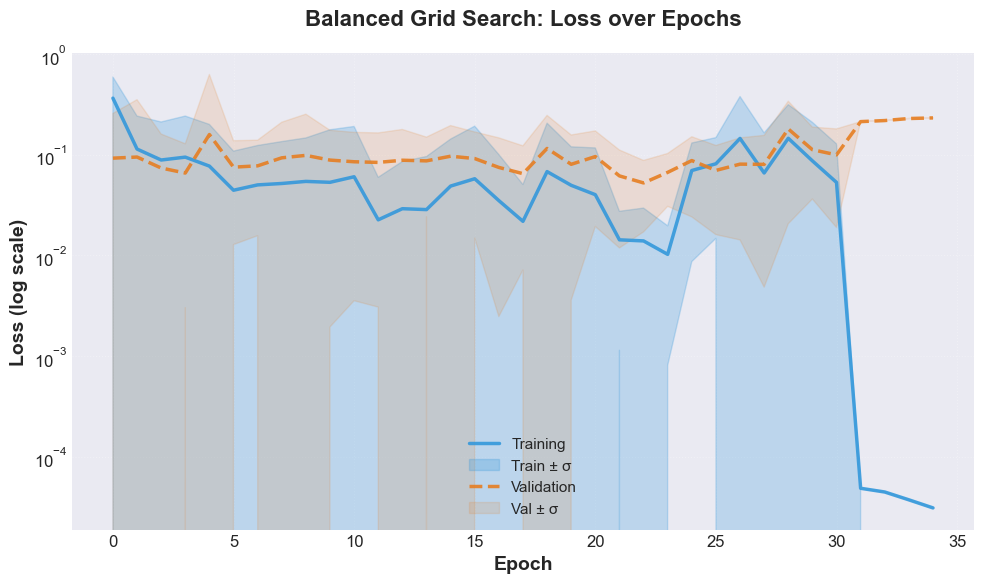

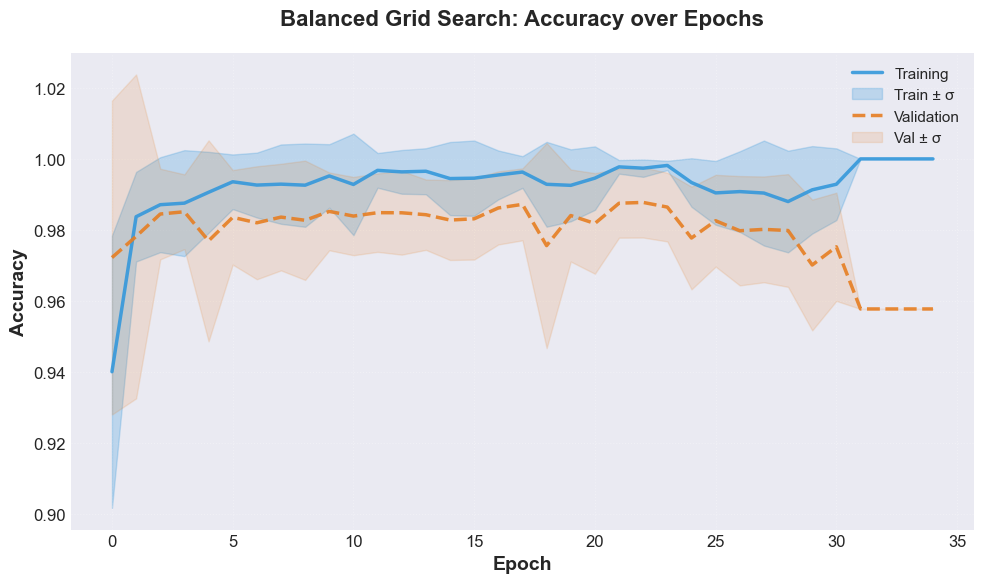


Generating plots for: imbalanced_grid_search


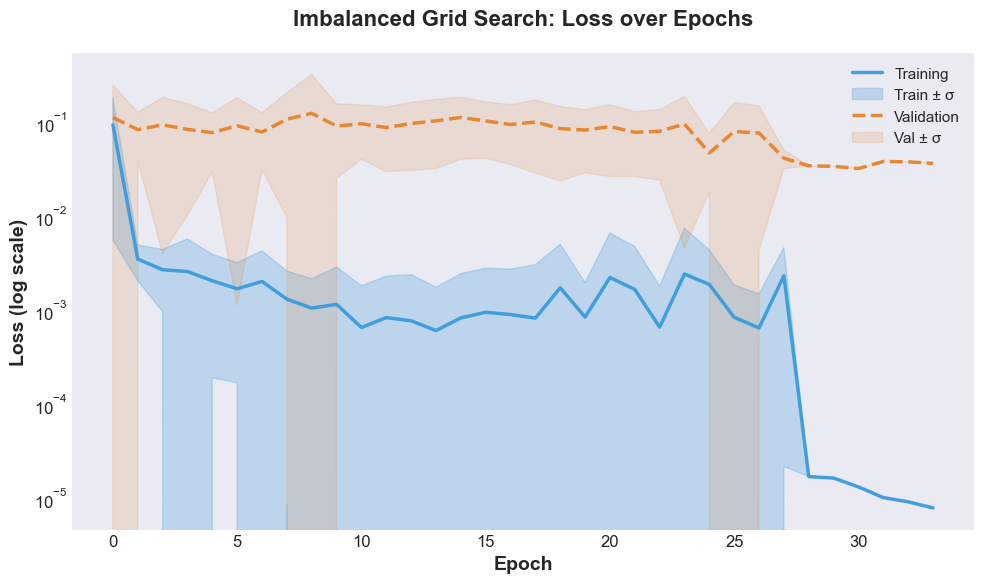

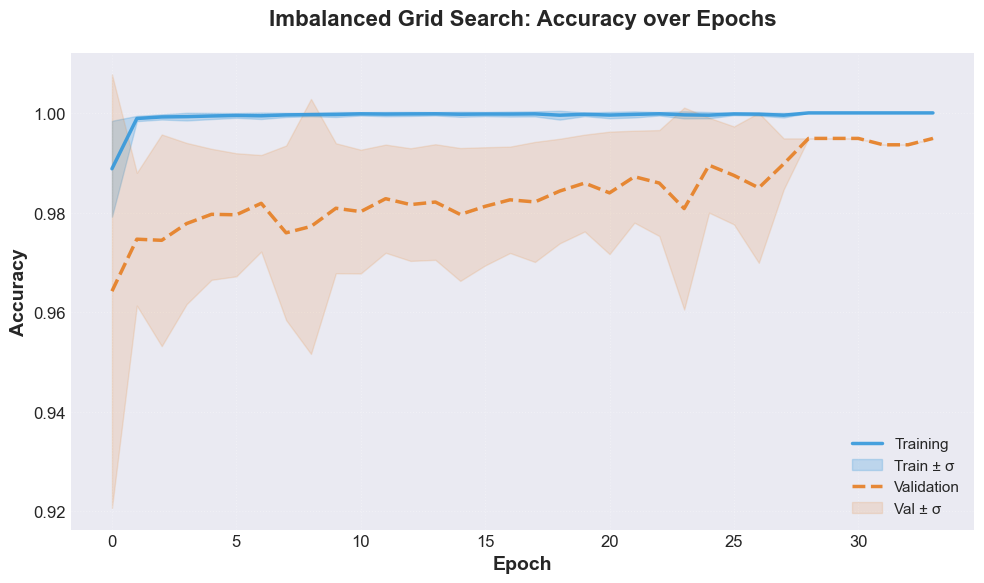

In [7]:
experiments = ['balanced_grid_search', 'imbalanced_grid_search']

for exp_name in experiments:
    df = aggregated_data[exp_name]
    
    print(f"\n{'='*60}")
    print(f"Generating plots for: {exp_name}")
    print(f"{'='*60}")
    
    # Plot 1: Loss (log scale)
    fig_loss = plot_single_experiment(
        df,
        exp_name=exp_name,
        metric_name='loss',
        ylabel='Loss',
        use_log_scale=True
    )
    plt.show()
    
    # Plot 2: Accuracy (linear scale)
    fig_acc = plot_single_experiment(
        df,
        exp_name=exp_name,
        metric_name='accuracy',
        ylabel='Accuracy',
        use_log_scale=False
    )
    plt.show()

In [8]:
# Print sample of aggregated data
for exp_name, df in aggregated_data.items():
    print(f"\n{exp_name}:")
    print(df.head(10))
    print(f"Shape: {df.shape}")


balanced_grid_search:
   global_epoch  train_loss_mean  train_loss_std  train_loss_count  \
0             0         0.364290        0.226987                40   
1             1         0.113824        0.128136                40   
2             2         0.088594        0.122827                40   
3             3         0.094618        0.147369                40   
4             4         0.077078        0.122890                40   
5             5         0.044394        0.064205                40   
6             6         0.050153        0.073311                40   
7             7         0.051798        0.083231                40   
8             8         0.054327        0.092395                40   
9             9         0.053204        0.123679                40   

   train_accuracy_mean  train_accuracy_std  train_accuracy_count  \
0             0.940075            0.038351                    40   
1             0.983716            0.012615                    40   
2 

In [9]:
# Check if std is too small
print(df[['global_epoch', 'train_loss_mean', 'train_loss_std']].head(10))

   global_epoch  train_loss_mean  train_loss_std
0             0         0.090880        0.085458
1             1         0.003419        0.001405
2             2         0.002634        0.001693
3             3         0.002522        0.003088
4             4         0.002009        0.001822
5             5         0.001654        0.001488
6             6         0.001977        0.002195
7             7         0.001283        0.001274
8             8         0.001030        0.001073
9             9         0.001131        0.001697
